# Comparing ndmg branches

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import nibabel as nib
from nilearn import plotting

/data/aloftus/.env/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## Metadata

- This analysis uses the KKI2009 data <a href="http://mrneurodata.s3-website-us-east-1.amazonaws.com/KKI2009/" target="_blank">here</a>.
- Docker containers were used.
    - <a href="https://hub.docker.com/r/bids/ndmg/" target="_blank">master</a>
    - <a href="https://hub.docker.com/r/neurodata/m3r-release/" target="_blank">eric's branch</a>, build 0.1.1
- I used the outputs in 
    - **master**: /graphs/ (.edgelist)
    - **eric**: /dwi/roi-connectomes (csv)

## Plan

1. Eric
    - Load data as np array
    - Convert to adjacency matrix
2. Master
    - Load data as np array
    - Convert to adjacency matrixc
3. Define a function that takes a file location as input and returns an adjacency matrix as output
    - Check whether file location is from master or eric
    - Possibly needs to do different things depending on which branch it's taking data from
4. For each pair of supposedly-equivalent graphs, take the difference
5. Take the norm of the above
6. Plot this for every parcellation
7. Equivalent analysis for group-level data if individual analysis looks good

## Show where data is coming from

In [2]:
# Show the data I ran on in a tree structure. Ignore the \xa0\xa0's. Ran on 3 of the subjects from the KKI2009 dataset.
%system tree -d -L 3 /data/aloftus/pr-diff/KKI/KKI2009

['/data/aloftus/pr-diff/KKI/KKI2009',
 '├── sub-113',
 '│\xa0\xa0 ├── ses-1',
 '│\xa0\xa0 │\xa0\xa0 ├── anat',
 '│\xa0\xa0 │\xa0\xa0 ├── dwi',
 '│\xa0\xa0 │\xa0\xa0 └── func',
 '│\xa0\xa0 └── ses-2',
 '│\xa0\xa0     ├── anat',
 '│\xa0\xa0     ├── dwi',
 '│\xa0\xa0     └── func',
 '├── sub-127',
 '│\xa0\xa0 ├── ses-1',
 '│\xa0\xa0 │\xa0\xa0 ├── anat',
 '│\xa0\xa0 │\xa0\xa0 ├── dwi',
 '│\xa0\xa0 │\xa0\xa0 └── func',
 '│\xa0\xa0 └── ses-2',
 '│\xa0\xa0     ├── anat',
 '│\xa0\xa0     ├── dwi',
 '│\xa0\xa0     └── func',
 '└── sub-142',
 '    ├── ses-1',
 '    │\xa0\xa0 ├── anat',
 '    │\xa0\xa0 ├── dwi',
 '    │\xa0\xa0 └── func',
 '    └── ses-2',
 '        ├── anat',
 '        ├── dwi',
 '        └── func',
 '',
 '27 directories']

In [3]:
# Show eric's branch output dir
%system tree -d -L 2 /data/aloftus/pr-diff/KKI/KKI-output/eric-branch/participant/dwi

['/data/aloftus/pr-diff/KKI/KKI-output/eric-branch/participant/dwi',
 '├── fiber',
 '├── preproc',
 '├── registered',
 '├── roi-connectomes',
 '│\xa0\xa0 ├── aal_res-1x1x1',
 '│\xa0\xa0 ├── brodmann_res-1x1x1',
 '│\xa0\xa0 ├── CPAC200_res-1x1x1',
 '│\xa0\xa0 ├── desikan_res-1x1x1',
 '│\xa0\xa0 ├── DK_res-1x1x1',
 '│\xa0\xa0 ├── DS00071_res-1x1x1',
 '│\xa0\xa0 ├── DS00096_res-1x1x1',
 '│\xa0\xa0 ├── DS00108_res-1x1x1',
 '│\xa0\xa0 ├── DS00140_res-1x1x1',
 '│\xa0\xa0 ├── DS00195_res-1x1x1',
 '│\xa0\xa0 ├── DS00278_res-1x1x1',
 '│\xa0\xa0 ├── DS00350_res-1x1x1',
 '│\xa0\xa0 ├── DS00446_res-1x1x1',
 '│\xa0\xa0 ├── DS00583_res-1x1x1',
 '│\xa0\xa0 ├── DS00833_res-1x1x1',
 '│\xa0\xa0 ├── DS01216_res-1x1x1',
 '│\xa0\xa0 ├── HarvardOxfordcort-maxprob-thr25_res-1x1x1',
 '│\xa0\xa0 ├── HarvardOxfordsub-maxprob-thr25_res-1x1x1',
 '│\xa0\xa0 ├── hemispheric_res-1x1x1',
 '│\xa0\xa0 ├── JHU_res-1x1x1',
 '│\xa0\xa0 ├── slab1068_res-1x1x1',
 '│\xa0\xa0 ├── slab907_res-1x1x1',
 '│\xa0\xa0 └── tissue_res

In [4]:
# Show master branch output dir
%system tree -d -L 2 /data/aloftus/pr-diff/KKI/KKI-output/master/graphs

['/data/aloftus/pr-diff/KKI/KKI-output/master/graphs',
 '├── AAL',
 '├── CPAC200',
 '├── desikan',
 '├── Desikan2012',
 '├── DS00071',
 '├── DS00096',
 '├── DS00108',
 '├── DS00140',
 '├── DS00195',
 '├── DS00278',
 '├── DS00350',
 '├── DS00446',
 '├── DS00583',
 '├── DS00833',
 '├── DS01216',
 '├── DS01876',
 '├── DS03231',
 '├── DS06481',
 '├── DS16784',
 '├── DS72784',
 '├── HarvardOxford',
 '├── JHU',
 '├── slab1068',
 '├── slab907',
 '└── Talairach',
 '',
 '25 directories']

## Load data

### Grab output for one subject, one session

- Using Desikan, sub-113, ses-1 for testing purposes

In [5]:
# Save directory data
eric_graphs = r'/data/aloftus/pr-diff/KKI/KKI-output/eric-branch/participant/dwi/roi-connectomes/DK_res-1x1x1/'
master_graphs = r'/data/aloftus/pr-diff/KKI/KKI-output/master/graphs/Desikan2012/'

In [6]:
# Show output csv files. Arbitrarily using ses-1 of sub-113 as testing data.
print(os.listdir(eric_graphs), '\n')
print(os.listdir(master_graphs))

['sub-113_ses-1_dwi_DK_res-1x1x1_measure-spatial-ds._elist.csv', 'sub-113_ses-2_dwi_DK_res-1x1x1_measure-spatial-ds._elist.csv', 'sub-142_ses-1_dwi_DK_res-1x1x1_measure-spatial-ds._elist.csv', 'sub-127_ses-2_dwi_DK_res-1x1x1_measure-spatial-ds._elist.csv', 'sub-142_ses-2_dwi_DK_res-1x1x1_measure-spatial-ds._elist.csv', 'sub-127_ses-1_dwi_DK_res-1x1x1_measure-spatial-ds._elist.csv'] 

['sub-127_ses-1_dwi_Desikan2012.edgelist', 'sub-113_ses-2_dwi_Desikan2012.edgelist', 'sub-142_ses-1_dwi_Desikan2012.edgelist', 'sub-142_ses-2_dwi_Desikan2012.edgelist', 'sub-127_ses-2_dwi_Desikan2012.edgelist', 'sub-113_ses-1_dwi_Desikan2012.edgelist']


In [7]:
# Get networkX graph for eric's sub-113-ses-1-JHU
eric_edgelist_location = eric_graphs + 'sub-113_ses-1_dwi_DK_res-1x1x1_measure-spatial-ds._elist.csv'
eric_nx = nx.read_weighted_edgelist(eric_edgelist_location, delimiter=',')

# Get networkX graph for masters's sub-113-ses-1-JHU
master_edgelist_location = master_graphs + 'sub-113_ses-1_dwi_Desikan2012.edgelist'
master_nx = nx.read_weighted_edgelist(master_edgelist_location, delimiter=' ')

## quick info about these two graphs
---

notable: nodes 1 and 3 are connected with edgeweights 38 for eric's branch and 21 for master.

In [8]:
# Quick look at the edgelists
pd.read_csv(eric_edgelist_location, delimiter=',', header=None).head()

,0,1,2
0,1,1,11916
1,1,2,575
2,1,3,38
3,1,36,4
4,1,37,1315


In [9]:
pd.read_csv(master_edgelist_location, header=None, delimiter=' ').head()

,0,1,2
0,1,34,3356
1,1,3,21
2,1,4,297
3,1,37,3542
4,1,6,1339


---

In [10]:
# Node ordering was different
list(eric_nx.nodes()) == list(master_nx.nodes())

False

In [11]:
sorted(list(eric_nx.nodes())) == sorted(list(master_nx.nodes()))

True

In [12]:
eric_mat = nx.to_numpy_matrix(eric_nx, nodelist=sorted(list(master_nx.nodes())))
master_mat = nx.to_numpy_matrix(master_nx, nodelist=sorted(list(master_nx.nodes())))

/data/aloftus/.env/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


In [13]:
np.fill_diagonal(eric_mat, 0)

In [14]:
eric_mat.astype(int)

matrix([[   0,    0,    0, ...,    0,    0,    0],
        [   0,    0, 2721, ...,    0,    0, 2106],
        [   0, 2721,    0, ...,    0,    0,   10],
        ...,
        [   0,    0,    0, ...,    0,   14,    0],
        [   0,    0,    0, ...,   14,    0,    0],
        [   0, 2106,   10, ...,    0,    0,    0]])

In [15]:
master_mat.astype(int)

matrix([[   0,   35,    0, ...,    0,    0,    0],
        [  35,    0, 1391, ...,    0,    0, 1134],
        [   0, 1391,    0, ...,    0,    0,    7],
        ...,
        [   0,    0,    0, ...,    0,   97,    0],
        [   0,    0,    0, ...,   97,    0,    0],
        [   0, 1134,    7, ...,    0,    0,    0]])

In [16]:
np.linalg.norm(eric_mat - master_mat, ord='fro')

38730.20074825329

## Resulting graphs

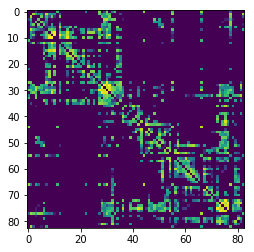

In [17]:
plt.imshow(np.log10(eric_mat + 1));

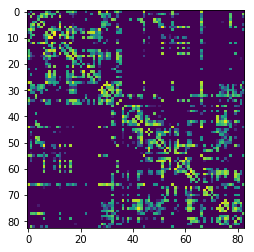

In [18]:
plt.imshow(np.log10(master_mat + 1));

## Check registered brains for equality

In [19]:
# variables for master
master_reg_loc = "/data/aloftus/pr-diff/KKI/KKI-output/master-debug/reg/dwi/sub-113_ses-1_dwi_aligned.nii.gz"
master_nib = nib.load(master_reg_loc)
master_aff = master_nib.affine

# variables for eric
eric_reg_loc = "/data/aloftus/pr-diff/KKI/KKI-output/eric-branch/participant/dwi/registered/sub-113_ses-1_dwi_space-MNI152NLin6_res-1x1x1_registered.nii.gz"
eric_nib = nib.load(eric_reg_loc)
eric_aff = eric_nib.affine

affine transformations are different

In [20]:
master_aff

array([[ -1.,   0.,   0.,  90.],
       [  0.,  -1.,   0.,  91.],
       [  0.,   0.,   1., -72.],
       [  0.,   0.,   0.,   1.]])

In [21]:
eric_aff

array([[  -1.,    0.,    0.,   90.],
       [   0.,    1.,    0., -126.],
       [   0.,    0.,    1.,  -72.],
       [   0.,    0.,    0.,    1.]])

/data/aloftus/.env/lib/python3.5/site-packages/nibabel/viewers.py:416: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  vdata = self._data[idx].ravel()


<OrthoSlicer3D: /data/aloftus/pr-diff/KKI/KKI-output/master-debug/reg/dwi/sub-113_ses-1_dwi_aligned.nii.gz (182, 218, 182, 34)>

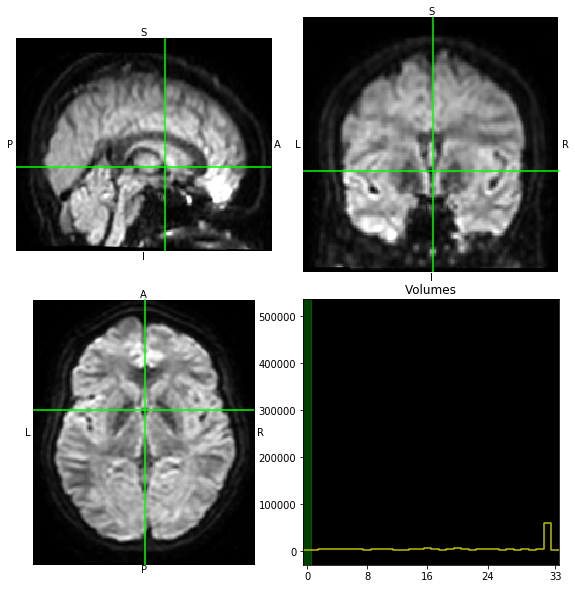

In [22]:
master_nib.orthoview()

<OrthoSlicer3D: /data/aloftus/pr-diff/KKI/KKI-output/eric-branch/participant/dwi/registered/sub-113_ses-1_dwi_space-MNI152NLin6_res-1x1x1_registered.nii.gz (182, 218, 182, 34)>

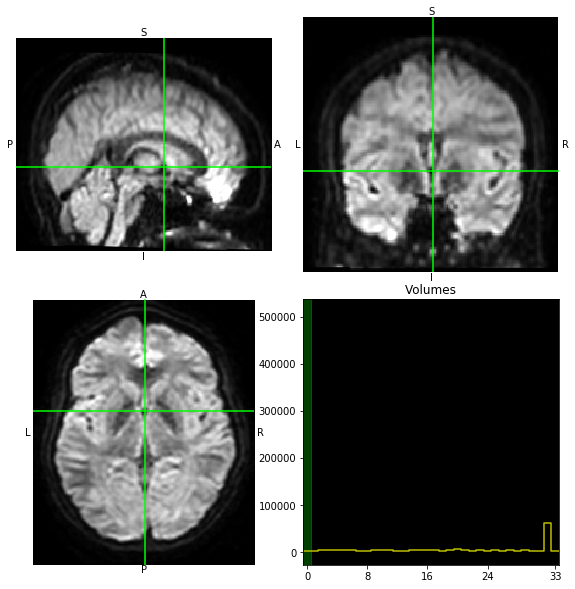

In [23]:
eric_nib.orthoview()

In [24]:
eric_data = eric_nib.get_data()
master_data = master_nib.get_data()

### The two registrations are flipped compared to each other.

In [25]:
np.all(eric_data == master_data)

False

In [26]:
eric_data.shape

(182, 218, 182, 34)

In [27]:
master_data.shape

(182, 218, 182, 34)

In [28]:
print(type(master_data))
print(type(eric_data))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


## Registrations plotted in space

In [29]:
from nilearn import image

In [30]:
master_3d = image.index_img(master_reg_loc, 0)
eric_3d = image.index_img(eric_reg_loc, 0)

### Registrations don't appear to be exactly the same

In [31]:
master_3d == eric_3d

False

/data/aloftus/.env/lib/python3.5/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


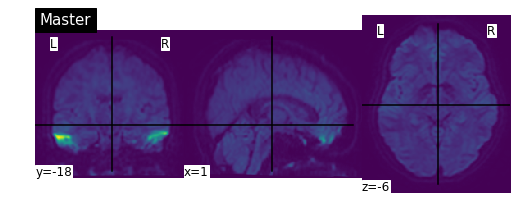

In [32]:
plotting.plot_img(master_3d, title='Master');

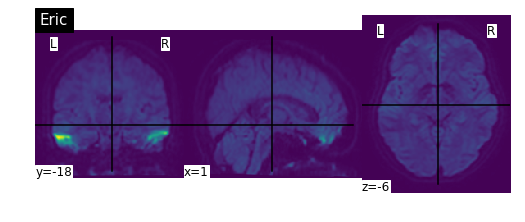

In [33]:
plotting.plot_img(eric_3d, title='Eric');

### Plotting at time 15 to see if the resulting images look different

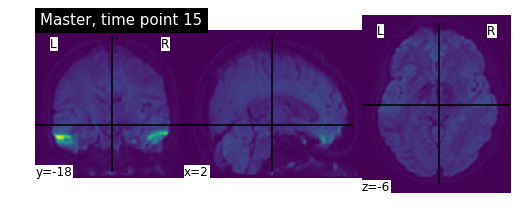

In [34]:
plotting.plot_img(image.index_img(master_reg_loc, 15), title='Master, time point 15');

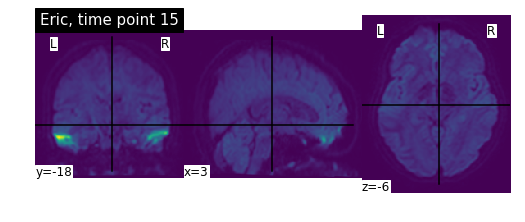

In [35]:
plotting.plot_img(image.index_img(eric_reg_loc, 15), title='Eric, time point 15');

- The master registration image and Eric's registration image don't *look* like they're flipped in space. Might be missing something.

## Fix affines

In [36]:
master_nib.affine

array([[ -1.,   0.,   0.,  90.],
       [  0.,  -1.,   0.,  91.],
       [  0.,   0.,   1., -72.],
       [  0.,   0.,   0.,   1.]])

In [37]:
eric_aff

array([[  -1.,    0.,    0.,   90.],
       [   0.,    1.,    0., -126.],
       [   0.,    0.,    1.,  -72.],
       [   0.,    0.,    0.,    1.]])

In [38]:
master_nib.header

In [39]:
# Make a Frankensteinish nifti image file with the affine of eric's registration image and the data from the master registration image.
master_nib_new = nib.Nifti1Image(master_nib.get_data(), eric_aff, header=master_nib.header)

## Compare graph overlays

In [40]:
# I realize that `from ndmg.qa_regdti import plot_overlays` would save this cell from needing to exist, but I wanted to make some minor edits to the code

import os
import re
import sys
import numpy as np
import nibabel as nb
from argparse import ArgumentParser
from scipy import ndimage
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
mpl.use('Agg')  # very important above pyplot import

import matplotlib.pyplot as plt

def reg_dti_pngs(dti, loc, atlas, outdir):
    """
    outdir: directory where output png file is saved
    fname: name of output file WITHOUT FULL PATH. Path provided in outdir.
    """

    atlas_data = nb.load(atlas).get_data()
    dti_data = nb.load(dti).get_data()
    b0_data = dti_data[:,:,:,loc]

    cmap1 = LinearSegmentedColormap.from_list('mycmap1', ['black', 'magenta'])
    cmap2 = LinearSegmentedColormap.from_list('mycmap2', ['black', 'green'])

    fig = plot_overlays(atlas_data, b0_data, (cmap1, cmap2))

    # name and save the file
    fname = os.path.split(dti)[1].split(".")[0] + '.png'
    plt.savefig(outdir + '/' + fname, format='png')


def plot_overlays(atlas, b0, cmaps):
    plt.rcParams.update({'axes.labelsize': 'x-large',
                         'axes.titlesize': 'x-large'})

    if b0.shape == (182, 218, 182):
        x = [78, 90, 100]
        y = [82, 107, 142]
        z = [88, 103, 107]
    else:
        shap = b0.shape
        x = [int(shap[0]*0.35), int(shap[0]*0.51), int(shap[0]*0.65)]
        y = [int(shap[1]*0.35), int(shap[1]*0.51), int(shap[1]*0.65)]
        z = [int(shap[2]*0.35), int(shap[2]*0.51), int(shap[2]*0.65)]
    coords = (x, y, z)

    labs = ['Sagittal Slice (YZ fixed)',
            'Coronal Slice (XZ fixed)',
            'Axial Slice (XY fixed)']
    var = ['X', 'Y', 'Z']
    # create subplot for first slice
    # and customize all labels
    idx = 0
    for i, coord in enumerate(coords):
        for pos in coord:
            idx += 1
            ax = plt.subplot(3, 3, idx)
            ax.set_title(var[i] + " = " + str(pos))
            if i == 0:
                image = ndimage.rotate(b0[pos, :, :], 90)
                atl = ndimage.rotate(atlas[pos, :, :], 90)
            elif i == 1:
                image = ndimage.rotate(b0[:, pos, :], 90)
                atl = ndimage.rotate(atlas[:, pos, :], 90)
            else:
                image = b0[:, :, pos]
                atl = atlas[:, :, pos]

            if idx % 3 == 1:
                ax.set_ylabel(labs[i])
                ax.yaxis.set_ticks([0, image.shape[0]/2, image.shape[0] - 1])
                ax.xaxis.set_ticks([0, image.shape[1]/2, image.shape[1] - 1])

            min_val_atl, max_val_atl = get_min_max(atl)  # Added this in from default ndmg
            min_val_img, max_val_img = get_min_max(image)
            plt.imshow(atl, interpolation='none', cmap=cmaps[0], alpha=0.5, vmin=min_val_atl, vmax=max_val_atl)
            plt.imshow(image, interpolation='none', cmap=cmaps[1], alpha=0.5,
                       vmin=min_val_img, vmax=max_val_img)

    fig = plt.gcf()
    fig.set_size_inches(12.5, 10.5, forward=True)
    return fig


def get_min_max(data):
    '''
    data: regdti data to threshold.
    '''
    min_val = np.percentile(data, 2)
    max_val = np.percentile(data, 95)
    return (min_val, max_val)


## They _**are**_ flipped in space

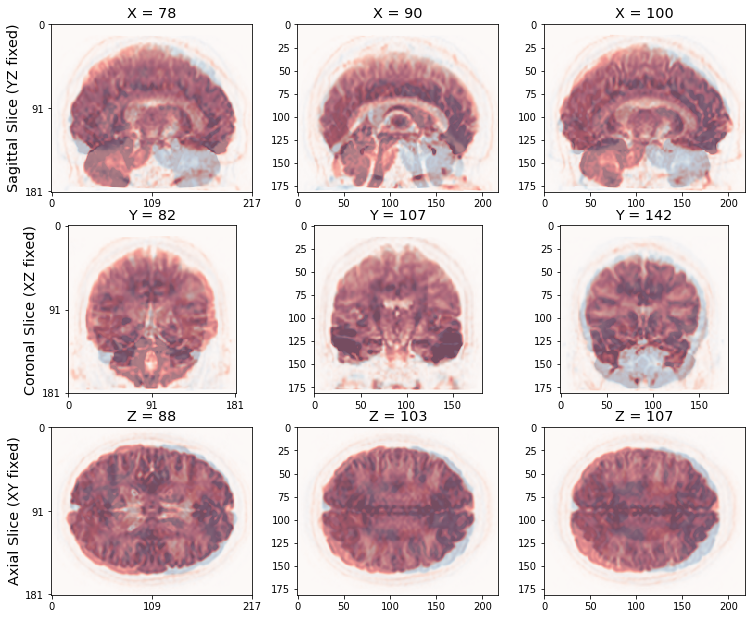

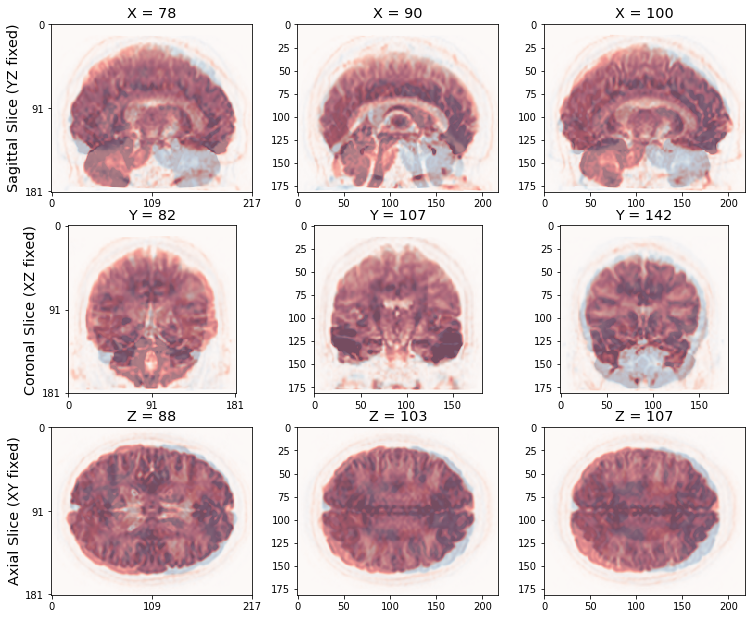

In [41]:
# So, master and eric branches are definitely flipped on the saggital plane, don't think adjusting the affine on the img object did anything. Need to figure out how to fix
plot_overlays(master_nib_new.get_data()[:, :, :, 0], eric_nib.get_data()[:, :, :, 0], cmaps=['Blues', 'Reds'])

## Overlays look correct with nibabel's flip_axis function

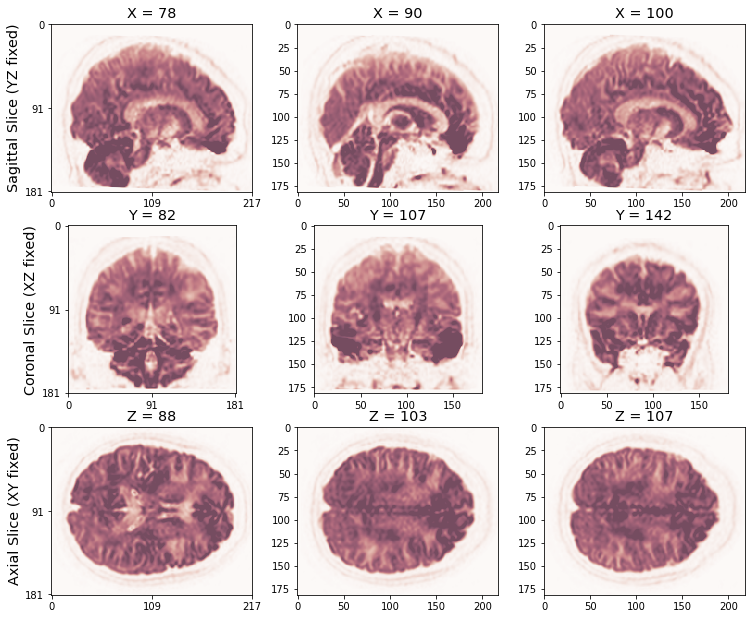

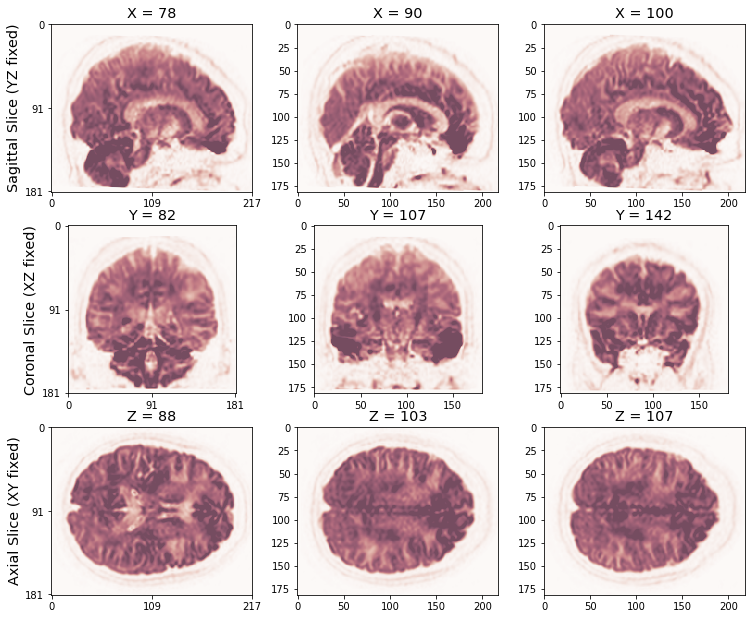

In [42]:
plot_overlays(nb.flip_axis(master_nib.get_data(), axis=1)[:, :, :, 0], eric_nib.get_data()[:, :, :, 0], cmaps=['Blues', 'Reds'])

## Get base data that's flipped to be in Eric's orientation

In [43]:
master_nib_new = nib.Nifti1Image(nb.flip_axis(master_nib.get_data(), axis=1), eric_aff, header=master_nib.header)

In [44]:
# master nib data still isn't the same as eric nib data
np.all(master_nib_new.get_data()[:, :, :, 0] == eric_nib.get_data()[:, :, :, 0])

False

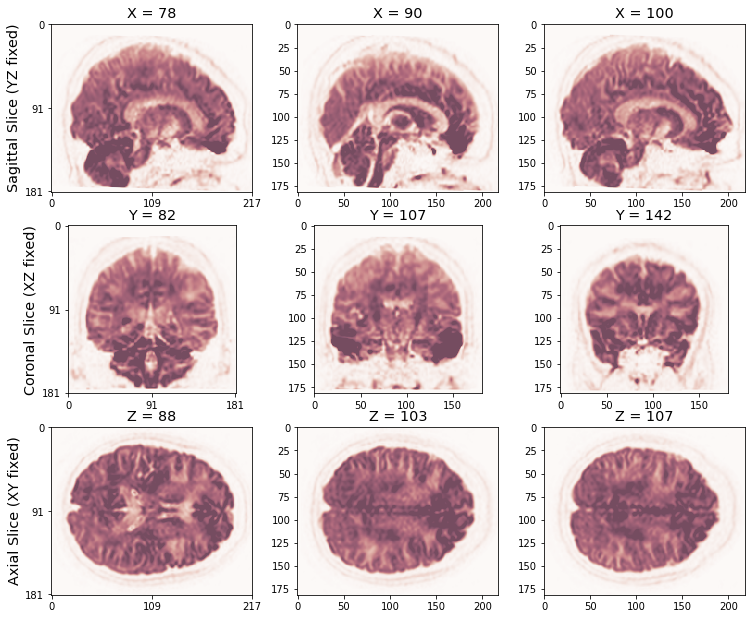

In [ ]:
plot_overlays(master_nib_new.get_data()[:, :, :, 0], eric_nib.get_data()[:, :, :, 0], cmaps=['Blues', 'Reds'])